In [161]:
import torch
import numpy as np
from glob import glob
import os
PATH = '/home/michael/Master-Thesis/CKIM_Competition/exp/Feature_Analysis_Graph-DC_FedVAE_2_out_global_private_NEW_sim_loss_lr_0_1_A0_F0_001_G0_001_H10_I5sim_loss_mse/FedDomSep_GraphDC_gin_on_fs_contest_data_lr0.1_lstep1_/features'

In [162]:
interm_trains = {1:[], 2:[],3:[], 4:[],5:[], 6:[],7:[], 8:[],9:[], 10:[],11:[], 12:[],13:[]}
global_trains = {1:[], 2:[],3:[], 4:[],5:[], 6:[],7:[], 8:[],9:[], 10:[],11:[], 12:[],13:[]}
local_trains = {1:[], 2:[],3:[], 4:[],5:[], 6:[],7:[], 8:[],9:[], 10:[],11:[], 12:[],13:[]}
labels = {1:[], 2:[],3:[], 4:[],5:[], 6:[],7:[], 8:[],9:[], 10:[],11:[], 12:[],13:[]}


In [163]:
all_files = [file
                 for path, subdir, files in os.walk(PATH)
                 for file in glob(os.path.join(path, '*.pt'))]
all_files.sort()

In [164]:
def get_files(path):
    for client in range(1, 13+1):
        client_path = f"{PATH}/client_{client}"
        all_files = [file
                 for path, subdir, files in os.walk(client_path)
                 for file in glob(os.path.join(path, '*.pt'))]
        all_files.sort()
        for file in all_files:
            file_name = os.path.basename(file)
            file_name_without_ending = file_name[:-3]
            if file_name_without_ending.startswith('global_val') and not file_name_without_ending.endswith('labels'):
                global_trains[client].append(torch.load(file).cpu().detach().numpy())
            if file_name_without_ending.startswith('interm_val') and not file_name_without_ending.endswith('labels'):
                interm_trains[client].append(torch.load(file).cpu().detach().numpy())
            if file_name_without_ending.startswith('local_val') and not file_name_without_ending.endswith('labels'):
                local_trains[client].append(torch.load(file).cpu().detach().numpy())
            if file_name_without_ending.startswith('val') and file_name_without_ending.endswith('labels'):
                labels[client].append(torch.load(file).cpu().detach().numpy())
        interm_trains[client] = np.concatenate(interm_trains[client])
        global_trains[client] = np.concatenate(global_trains[client])
        local_trains[client] = np.concatenate(local_trains[client])
        labels[client] = np.concatenate(labels[client])


In [165]:
get_files(PATH)

In [166]:
import numpy as np
#concat_X=global_train
data_out_global = {}
data_out_interm = {}

for key in interm_trains.keys():
    data_out_global[key] = global_trains[key] + local_trains[key]
    data_out_interm[key] = interm_trains[key] + local_trains[key]

X_concat_global = []
X_concat_interm = []
labels_concat = []

for key in interm_trains.keys():
    X_concat_global.append(data_out_global[key])
    X_concat_interm.append(data_out_interm[key])
    labels_concat.append(labels[key])

X_concat_global = np.concatenate(X_concat_global)
X_concat_interm = np.concatenate(X_concat_interm)
labels_concat = np.concatenate(labels_concat)

In [167]:
from sklearn.manifold import TSNE

In [168]:
labels_global = labels.copy()


In [169]:
X_concat = np.concatenate([X_concat_global, X_concat_interm])
labels_double_concat = np.concatenate([labels_concat])

In [170]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=25).fit_transform(X_concat, labels_double_concat)

In [171]:
X_embedded.shape[0]//2

3883

In [172]:
# Feature Analysis for client 9:
global_trains[9]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.04100671, 0.01817902, 0.        , ..., 0.00676296, 0.        ,
        0.        ],
       [0.21705593, 0.        , 0.14356993, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00044574, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00113354, 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [173]:
interm_trains[9]

array([[0.        , 0.        , 0.06633493, ..., 0.        , 0.07383461,
        0.08833515],
       [0.        , 0.        , 0.0421936 , ..., 0.        , 0.06168297,
        0.0753582 ],
       [0.08804238, 0.        , 0.        , ..., 0.0120199 , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [174]:
local_trains[9]

array([[0.        , 0.04821999, 0.15788074, ..., 0.09434089, 0.        ,
        0.        ],
       [0.        , 0.        , 0.09743346, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.07943188, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.217564  , 0.        , ..., 0.25096723, 0.        ,
        0.        ],
       [0.        , 0.10640317, 0.        , ..., 0.11995811, 0.        ,
        0.        ]], dtype=float32)

In [175]:
cos_sim = torch.nn.CosineSimilarity()

In [176]:
for client in range(1, 13+1):


    local_train_curr = local_trains[client]
    interm_train_curr = interm_trains[client]
    global_train_curr = global_trains[client]

    num_total_features = local_train_curr.shape[0] * local_train_curr.shape[1]

    local_interm = local_train_curr + interm_train_curr
    local_global = local_train_curr + global_train_curr

    mult_local_interm = local_train_curr*interm_train_curr
    mult_local_global = global_train_curr*local_train_curr
    mult_global_interm = interm_train_curr*global_train_curr

    num_local_features_not_0 =  np.sum(local_train_curr != 0) / num_total_features
    avg_local_features_not_0 =  local_train_curr.sum() / np.sum(local_train_curr != 0)
    num_global_features_not_0 =  np.sum(global_train_curr != 0) / num_total_features
    avg_global_features_not_0 =  global_train_curr.sum() / np.sum(global_train_curr != 0)
    num_interm_features_not_0 =  np.sum(interm_train_curr != 0) / num_total_features
    avg_interm_features_not_0 =  interm_train_curr.sum() / np.sum(interm_train_curr != 0)

    num_features_global_local = np.sum(mult_local_global != 0) / num_total_features
    num_features_interm_local = np.sum(mult_local_interm != 0) / num_total_features
    num_features_global_interm = np.sum(mult_global_interm != 0) / num_total_features


    cos_sim_global_interm = cos_sim(torch.Tensor(global_train_curr), torch.Tensor(interm_train_curr)).mean()
    cos_sim_local_local_interm = cos_sim(torch.Tensor(local_train_curr), torch.Tensor(local_interm)).mean()
    cos_sim_local_local_global = cos_sim(torch.Tensor(local_train_curr), torch.Tensor(local_global)).mean()

    print(f"############ Client {client} ##############")
    print(f"total features: {num_total_features}")
    print(f"num_local_features_not_0: {num_local_features_not_0}")
    print(f"avg_local_features_not_0: {avg_local_features_not_0}")

    print(f"num_interm_features_not_0: {num_interm_features_not_0}")
    print(f"num_features_interm_local: {num_features_interm_local}")
    print(f"avg_interm_features_not_0: {avg_interm_features_not_0}")

    print(f"num_global_features_not_0: {num_global_features_not_0}")
    print(f"num_features_global_local: {num_features_global_local}")
    print(f"num_features_global_interm: {num_features_global_interm}")
    print(f"avg_global_features_not_0: {avg_global_features_not_0}")

    print(f"cos_sim_global_interm: {cos_sim_global_interm}")
    print(f"cos_sim_local_local_interm: {cos_sim_local_local_interm}")
    print(f"cos_sim_local_local_global: {cos_sim_local_local_global}")


############ Client 1 ##############
total features: 2432
num_local_features_not_0: 0.46463815789473684
avg_local_features_not_0: 0.5076114620782632
num_interm_features_not_0: 0.1796875
num_features_interm_local: 0.08388157894736842
avg_interm_features_not_0: 0.05720647030618698
num_global_features_not_0: 0.0962171052631579
num_features_global_local: 0.04523026315789474
num_features_global_interm: 0.011924342105263159
avg_global_features_not_0: 0.08280677469367655
cos_sim_global_interm: 0.040131427347660065
cos_sim_local_local_interm: 0.9923302531242371
cos_sim_local_local_global: 0.9848066568374634
############ Client 2 ##############
total features: 5184
num_local_features_not_0: 0.4018132716049383
avg_local_features_not_0: 0.24245388051150685
num_interm_features_not_0: 0.1545138888888889
num_features_interm_local: 0.06905864197530864
avg_interm_features_not_0: 0.034077928902653425
num_global_features_not_0: 0.0943287037037037
num_features_global_local: 0.044174382716049385
num_featu

In [177]:
local_trains[9].sum() / np.sum(local_trains[9] != 0)

0.11390943398819997

In [178]:
np.sum(local_trains[9] != 0)

16340

In [179]:
np.sum(interm_trains[9] != 0)

9957

In [180]:
interm_trains[9].sum() / np.sum(interm_trains[9] != 0)

0.05628024970262755

In [181]:
global_trains[9].sum() / np.sum(global_trains[9] != 0)

0.0688142922621898

In [182]:
np.sum(global_trains[9] != 0)

6004

In [183]:
global_trains[9].shape[0] * global_trains[9].shape[1]

52800

In [184]:
X_embedded_global = X_embedded[:3883,:]
X_embedded_interm = X_embedded[3883:,:]

In [185]:
#X_embedded_global = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=25).fit_transform(X_concat_global, labels_concat)
#X_embedded_local = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=25).fit_transform(X_concat_interm, labels_concat)
#X_embedded_interm = X_embedded_local

In [186]:
#X_embedded_interm = X_embedded_local

In [187]:
X_embedded_global_clients = {}
X_embedded_interm_clients = {}
labels_clients = {}
total_size = 0

for client in range(1, 13+1):
    print(f"size client {client}: {interm_trains[client].shape[0]}")
    size = interm_trains[client].shape[0]
    size_old = total_size
    total_size += size
    X_embedded_global_clients[client] = X_embedded_global[size_old:total_size,:]
    X_embedded_interm_clients[client] = X_embedded_interm[size_old:total_size,:]
    labels_clients[client] = labels_concat[size_old:total_size]

size client 1: 38
size client 2: 81
size client 3: 93
size client 4: 151
size client 5: 69
size client 6: 400
size client 7: 822
size client 8: 867
size client 9: 825
size client 10: 67
size client 11: 70
size client 12: 200
size client 13: 200


In [188]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(30, 18))
plt.rcParams["figure.figsize"] = (30,18)

<Figure size 3000x1800 with 0 Axes>

In [189]:
"""yellow: label=1"""

'yellow: label=1'

In [190]:
client_num = 13

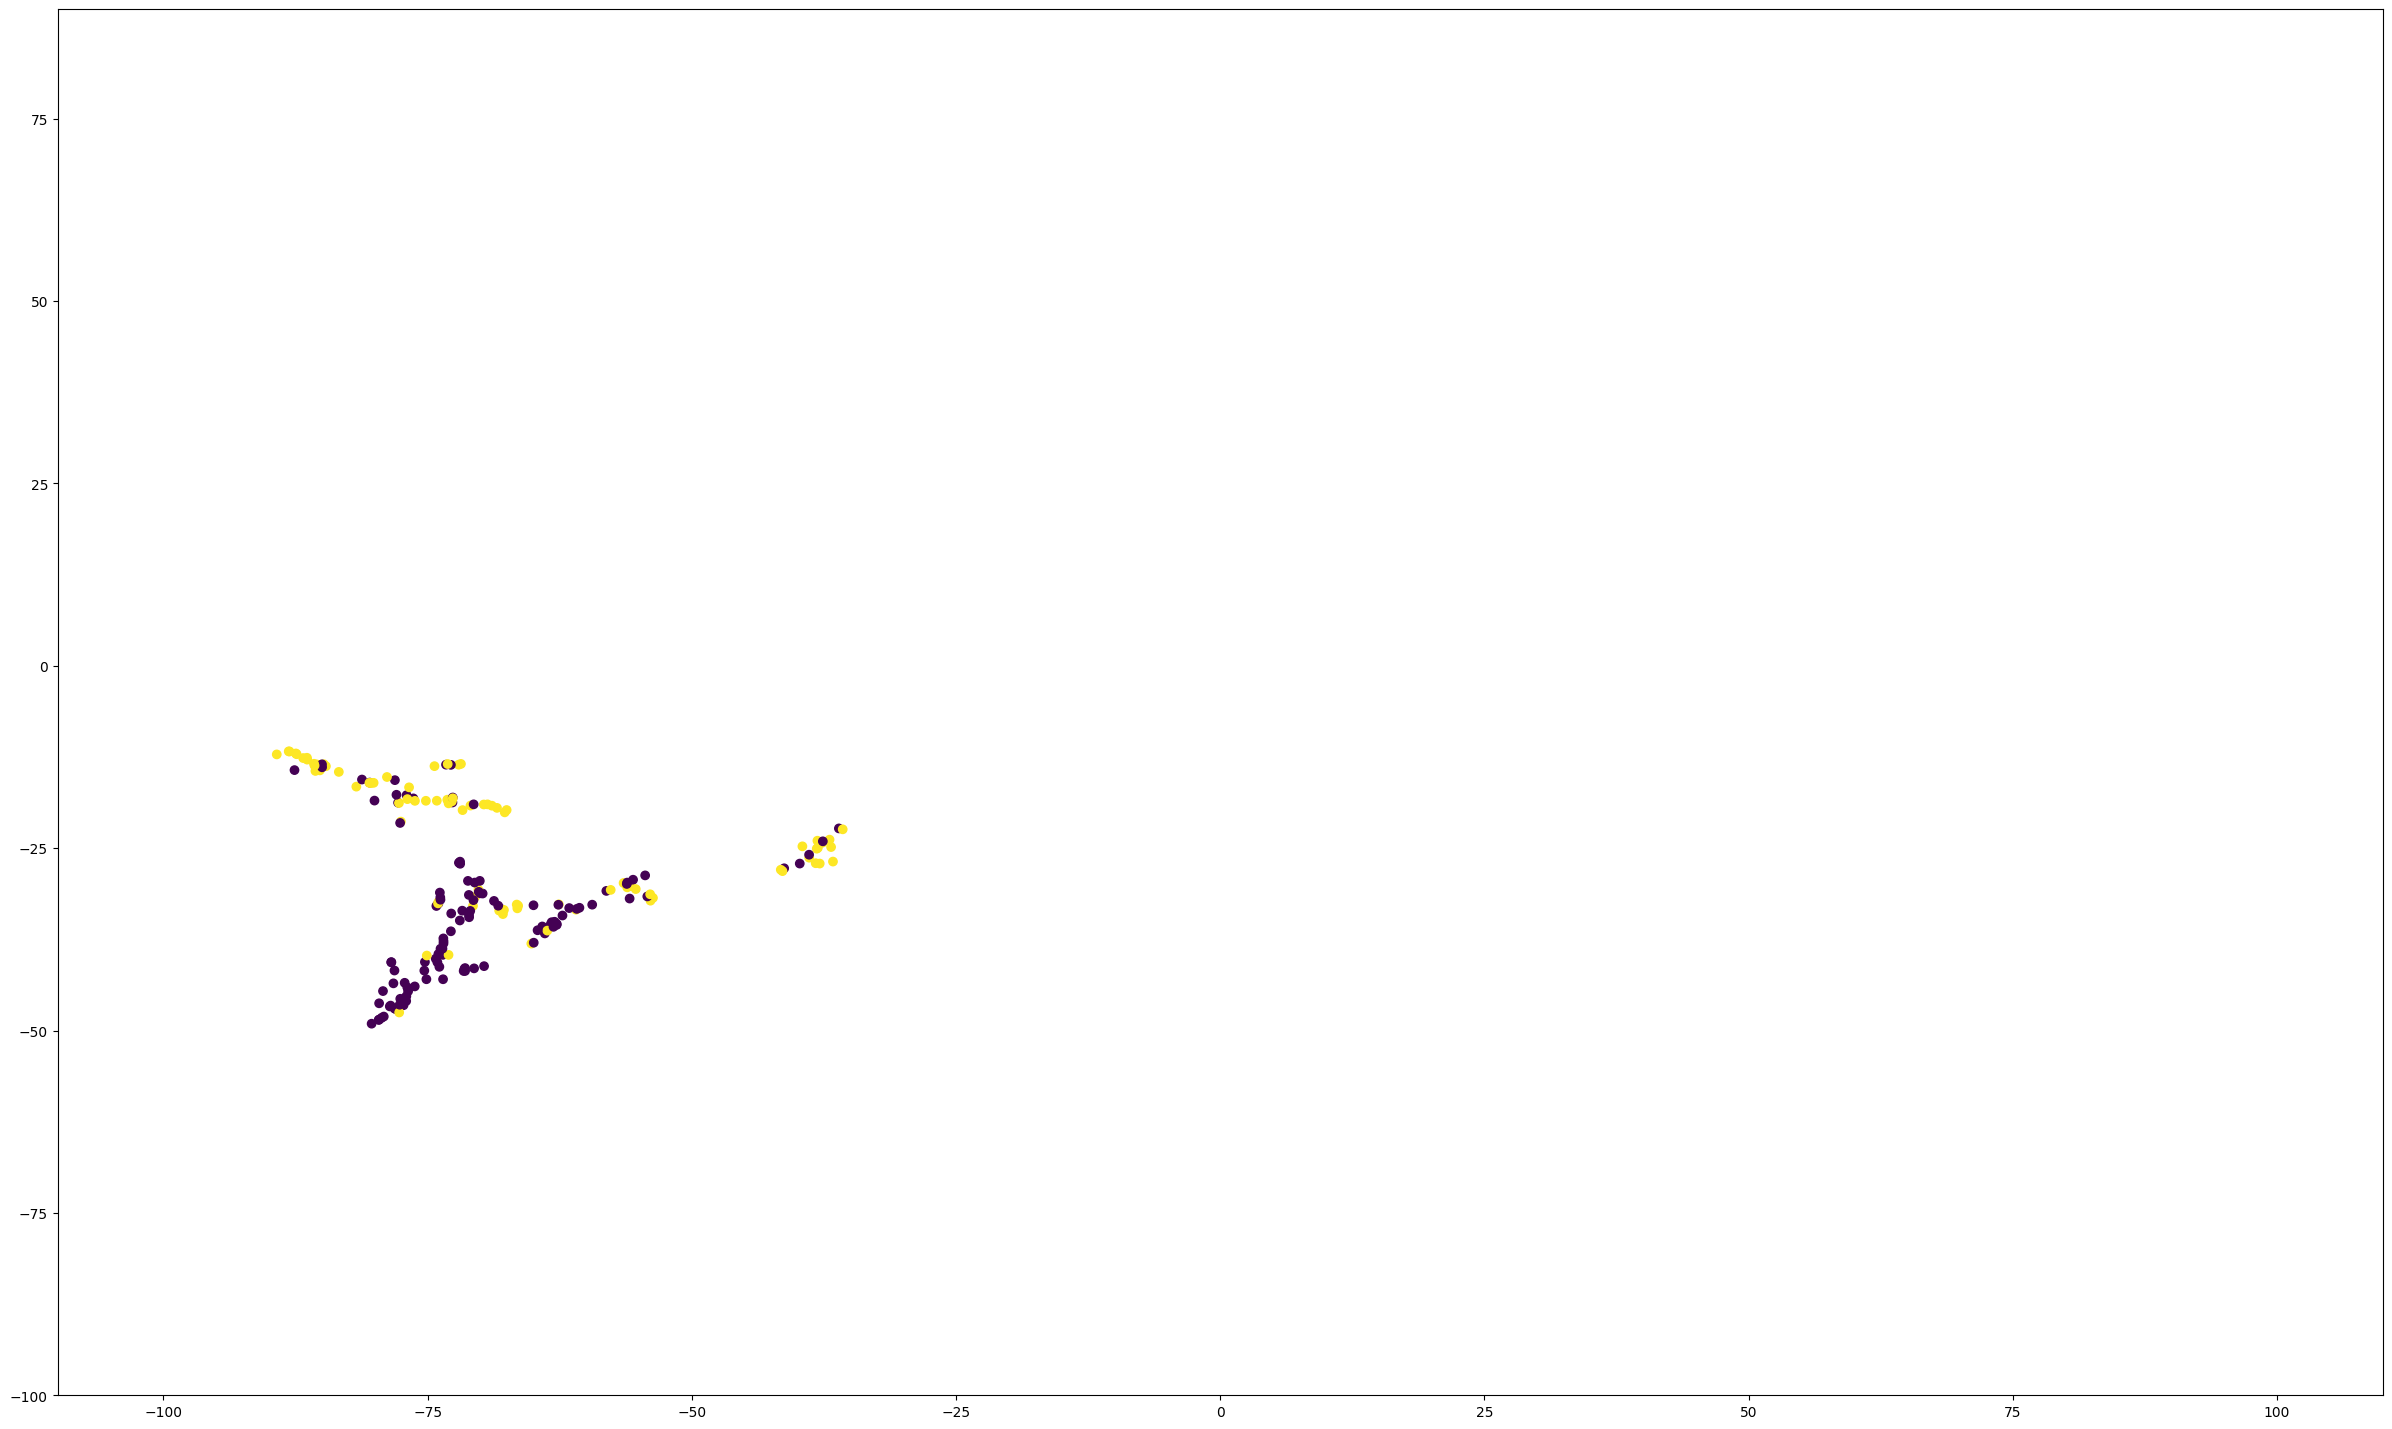

In [191]:
plt.scatter(X_embedded_global_clients[client_num][:, 0], X_embedded_global_clients[client_num][:, 1], c=labels_clients[client_num], )
plt.xlim(-110, 110)
plt.ylim(-100, 90)
plt.show()

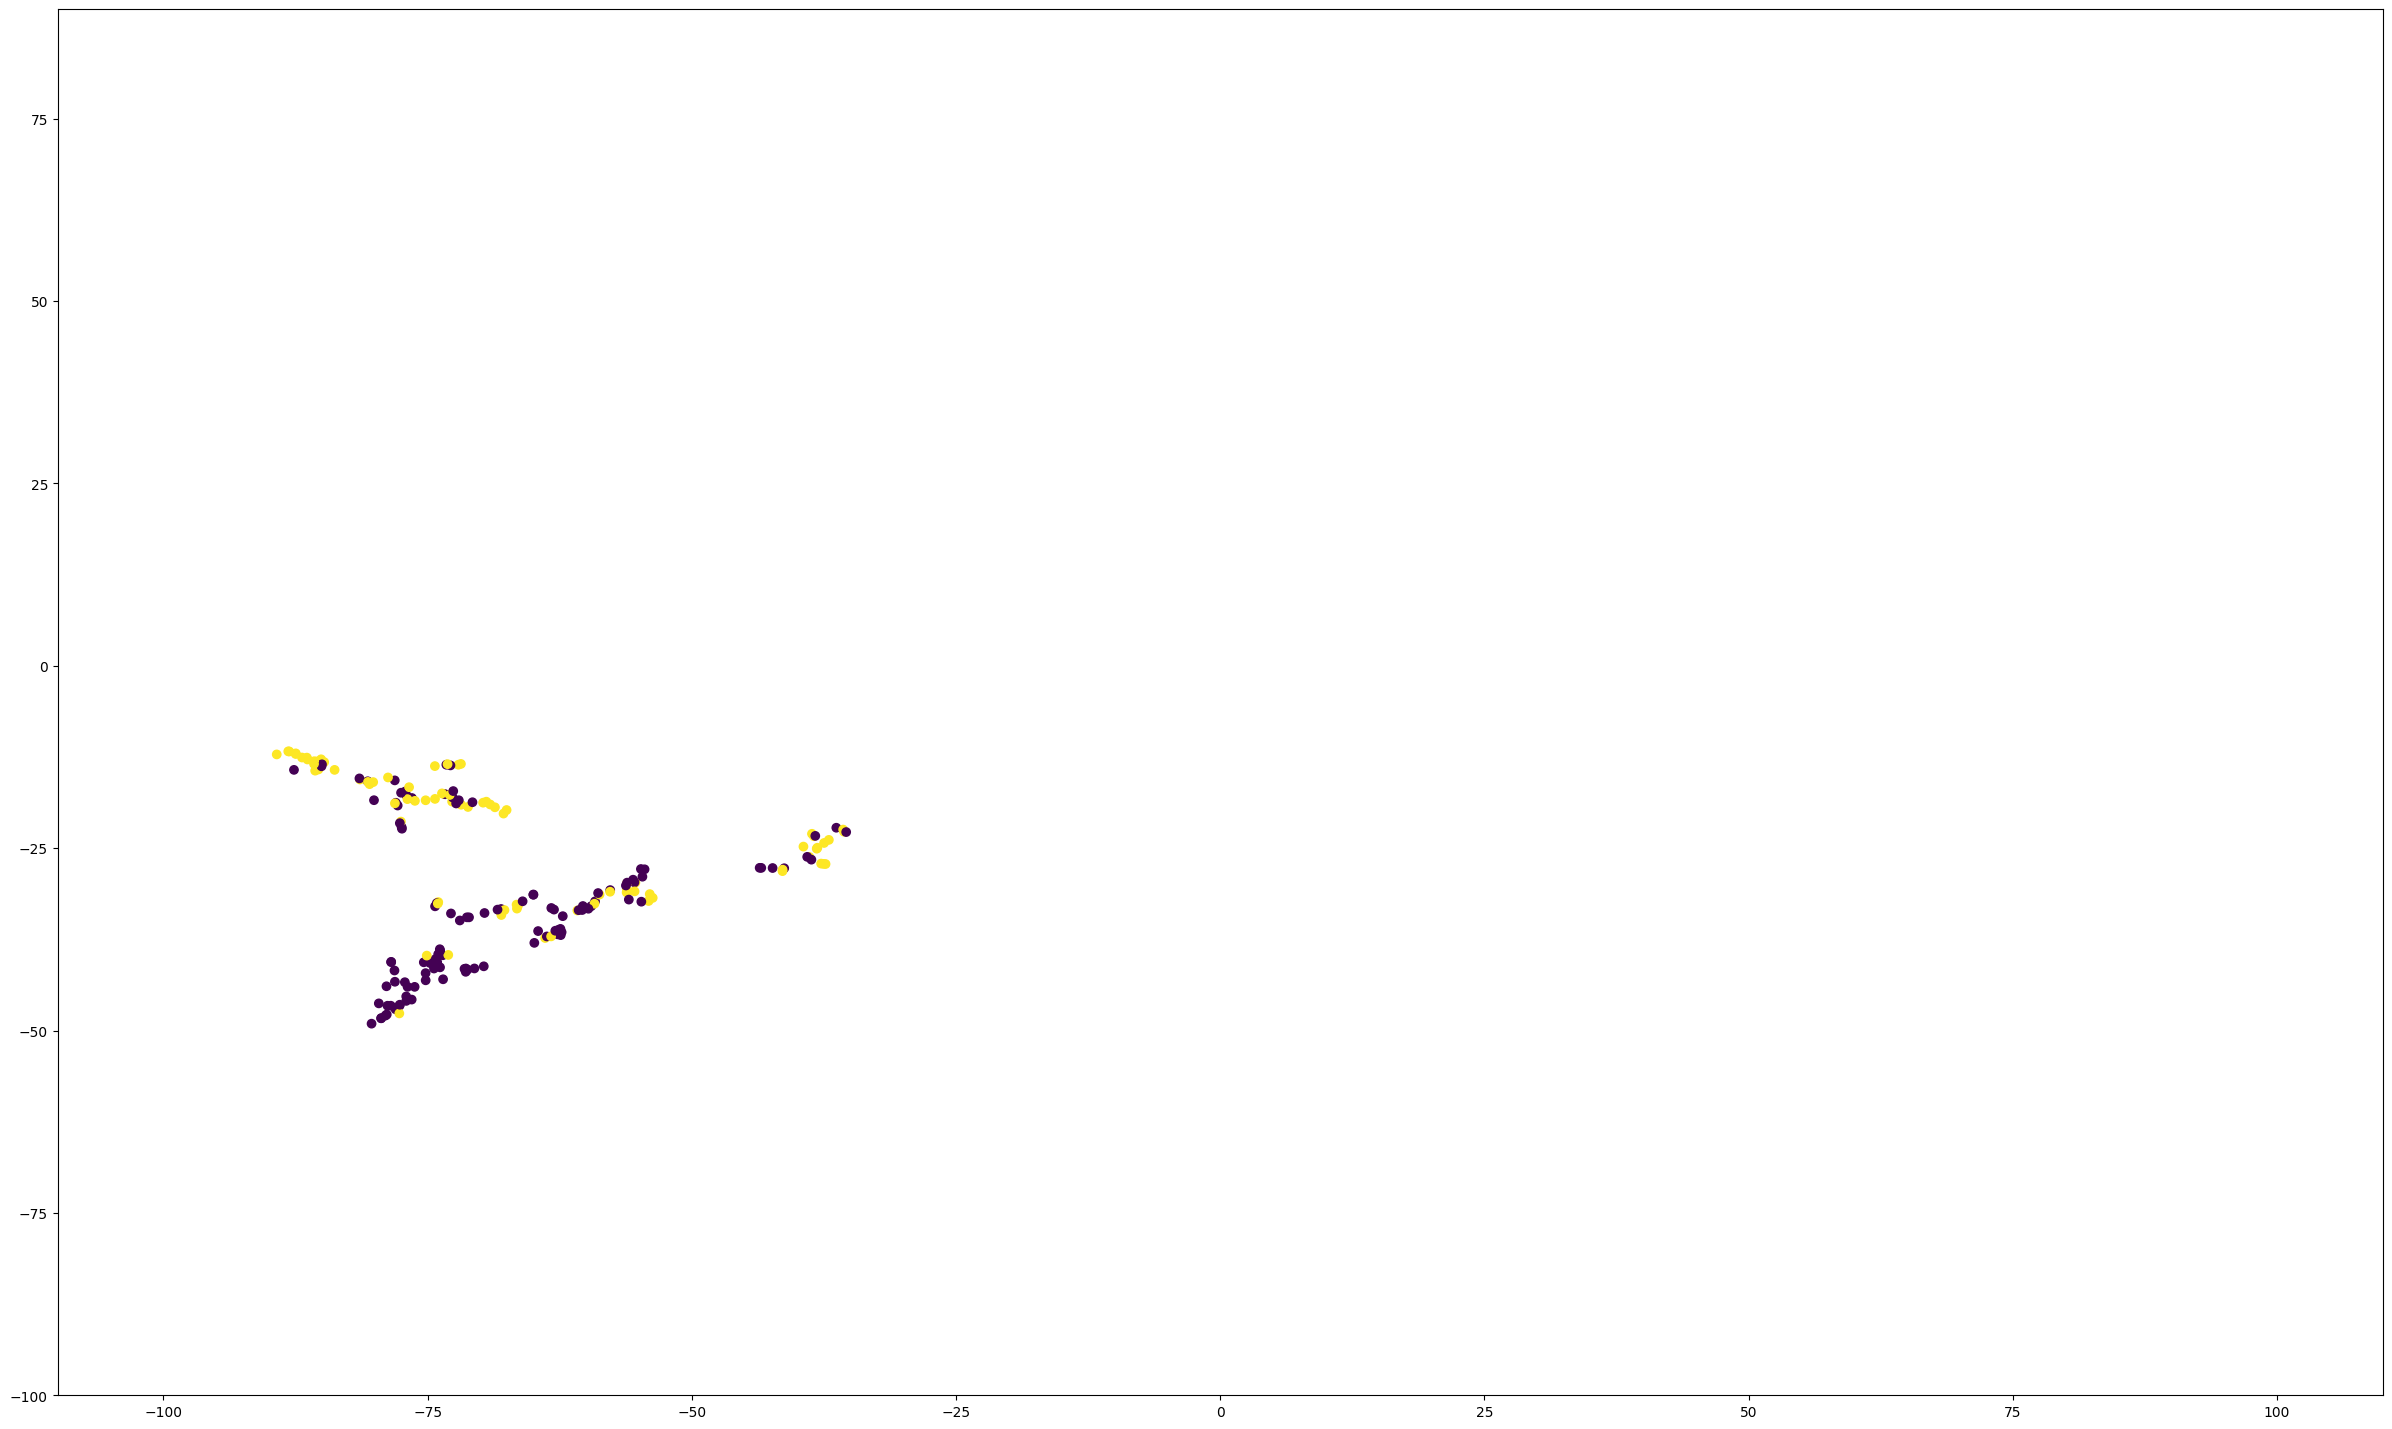

In [192]:
plt.scatter(X_embedded_interm_clients[client_num][:, 0], X_embedded_interm_clients[client_num][:, 1], c=labels_clients[client_num], )
plt.xlim(-110, 110)
plt.ylim(-100, 90)
plt.show()

In [193]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(30, 18))
plt.rcParams["figure.figsize"] = (30,18)

<Figure size 3000x1800 with 0 Axes>

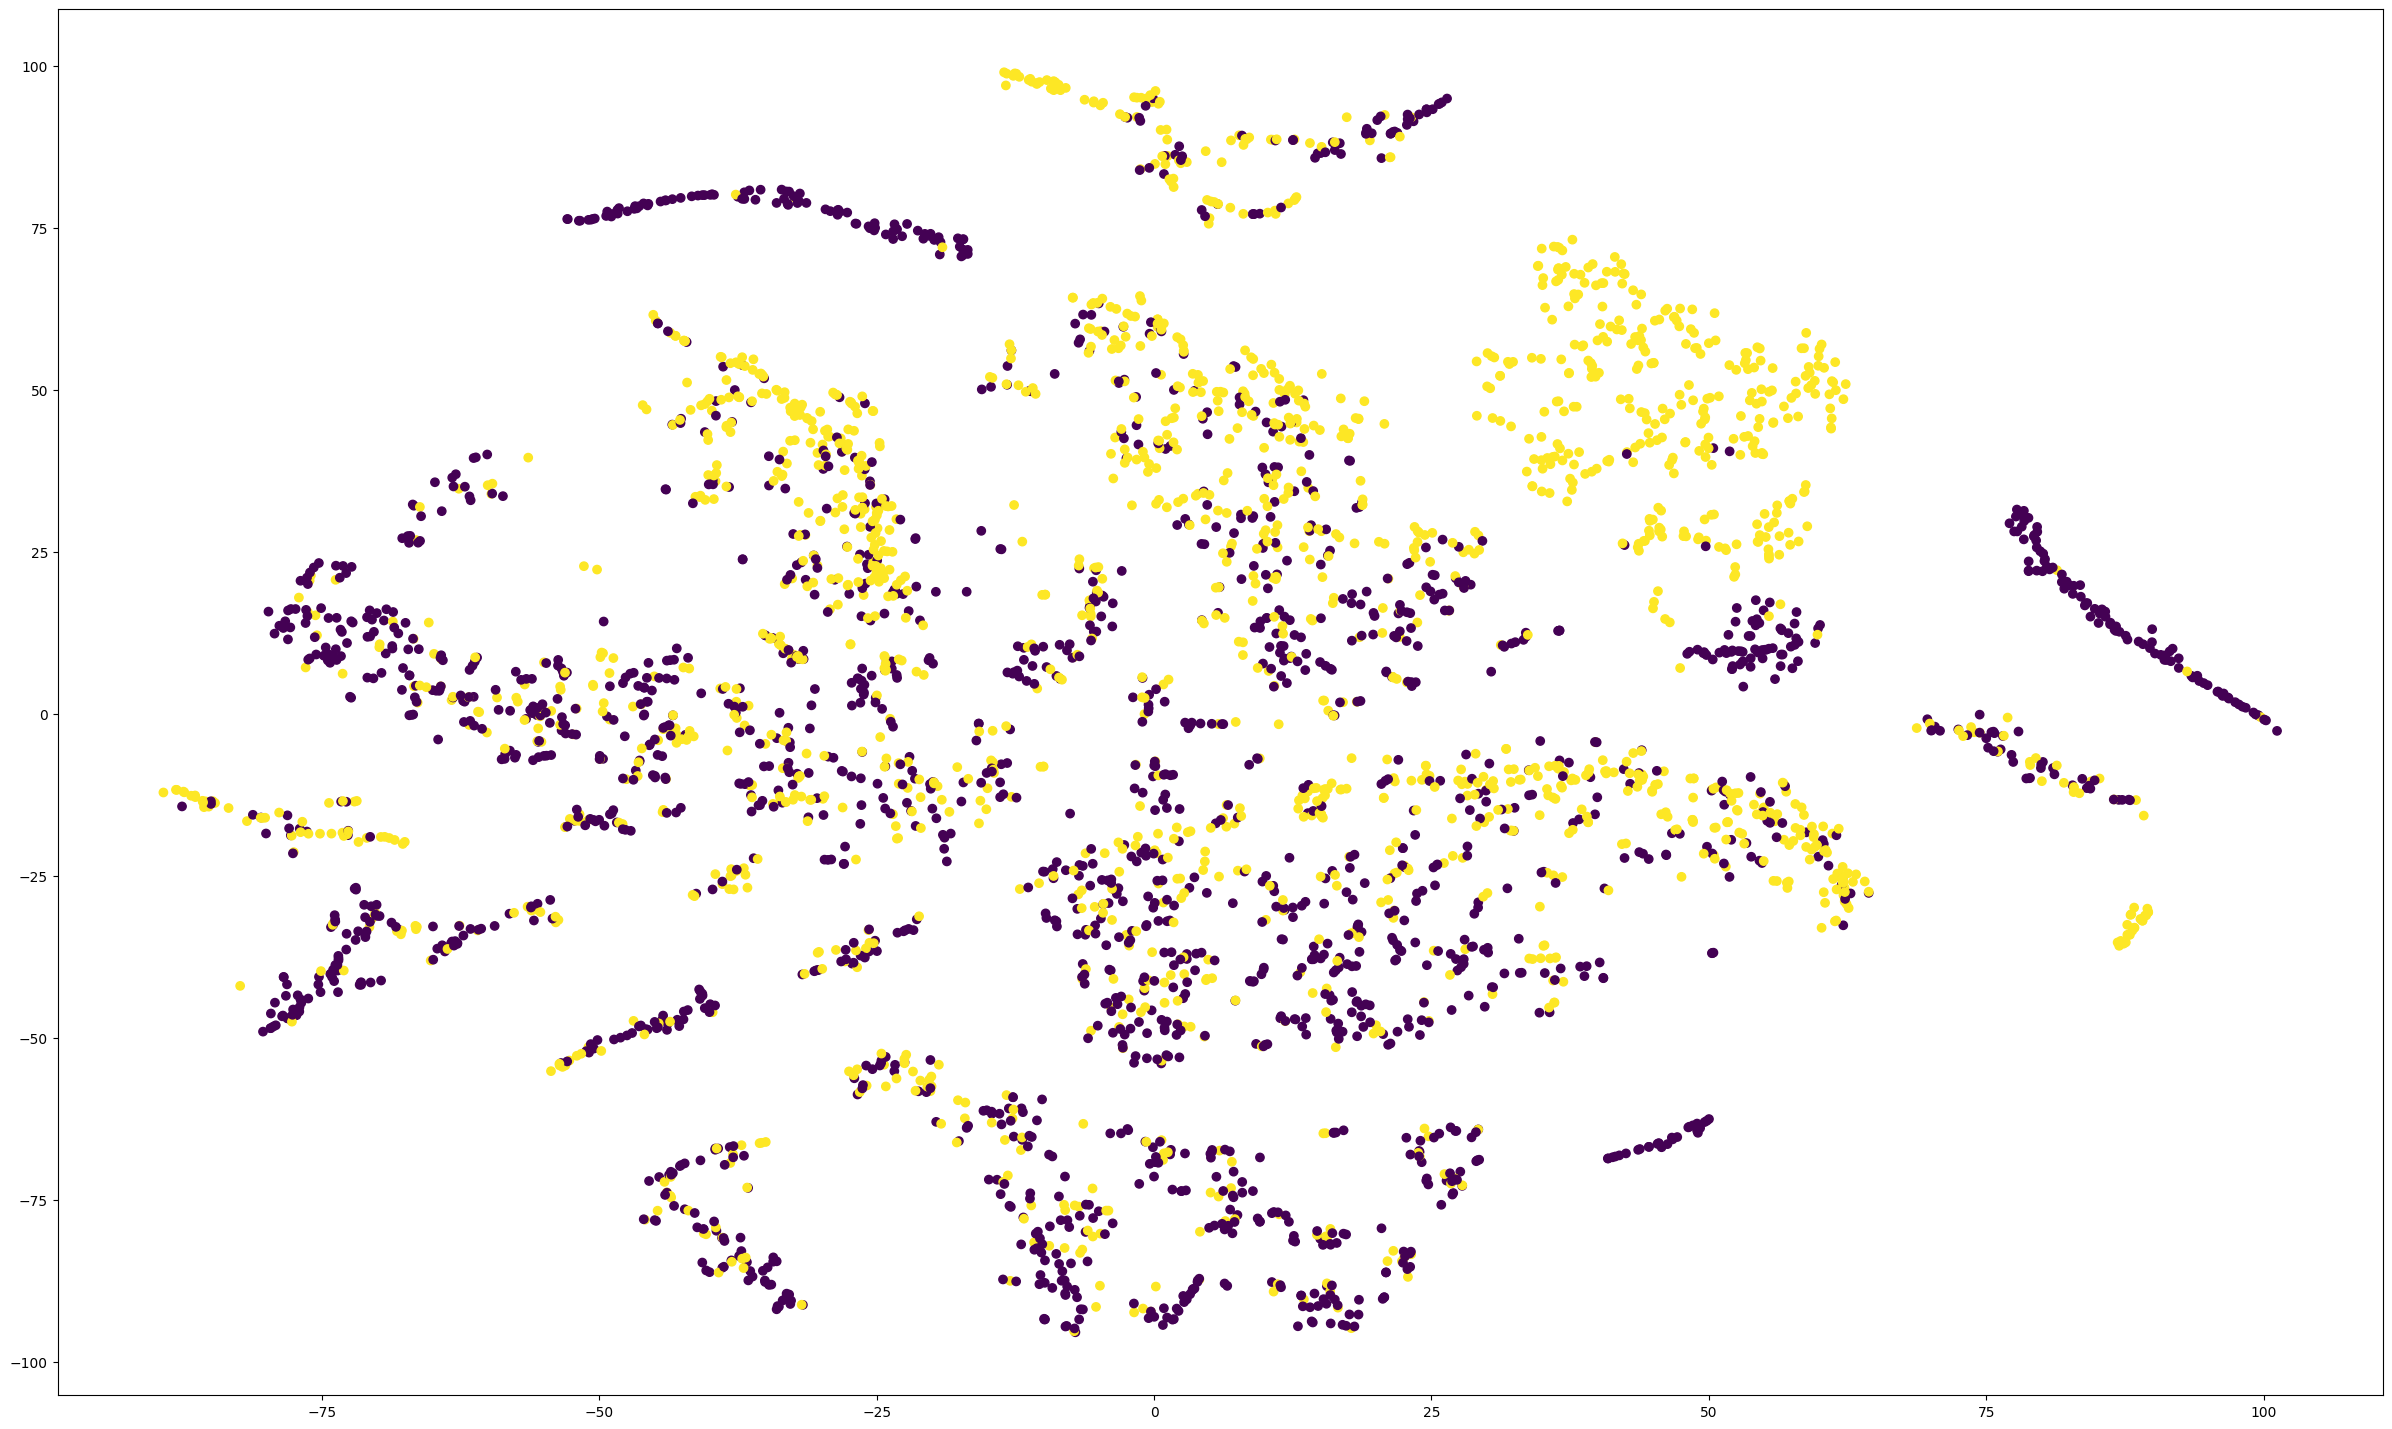

In [194]:
plt.scatter(X_embedded_global[:, 0], X_embedded_global[:, 1], c=labels_concat)
plt.show()

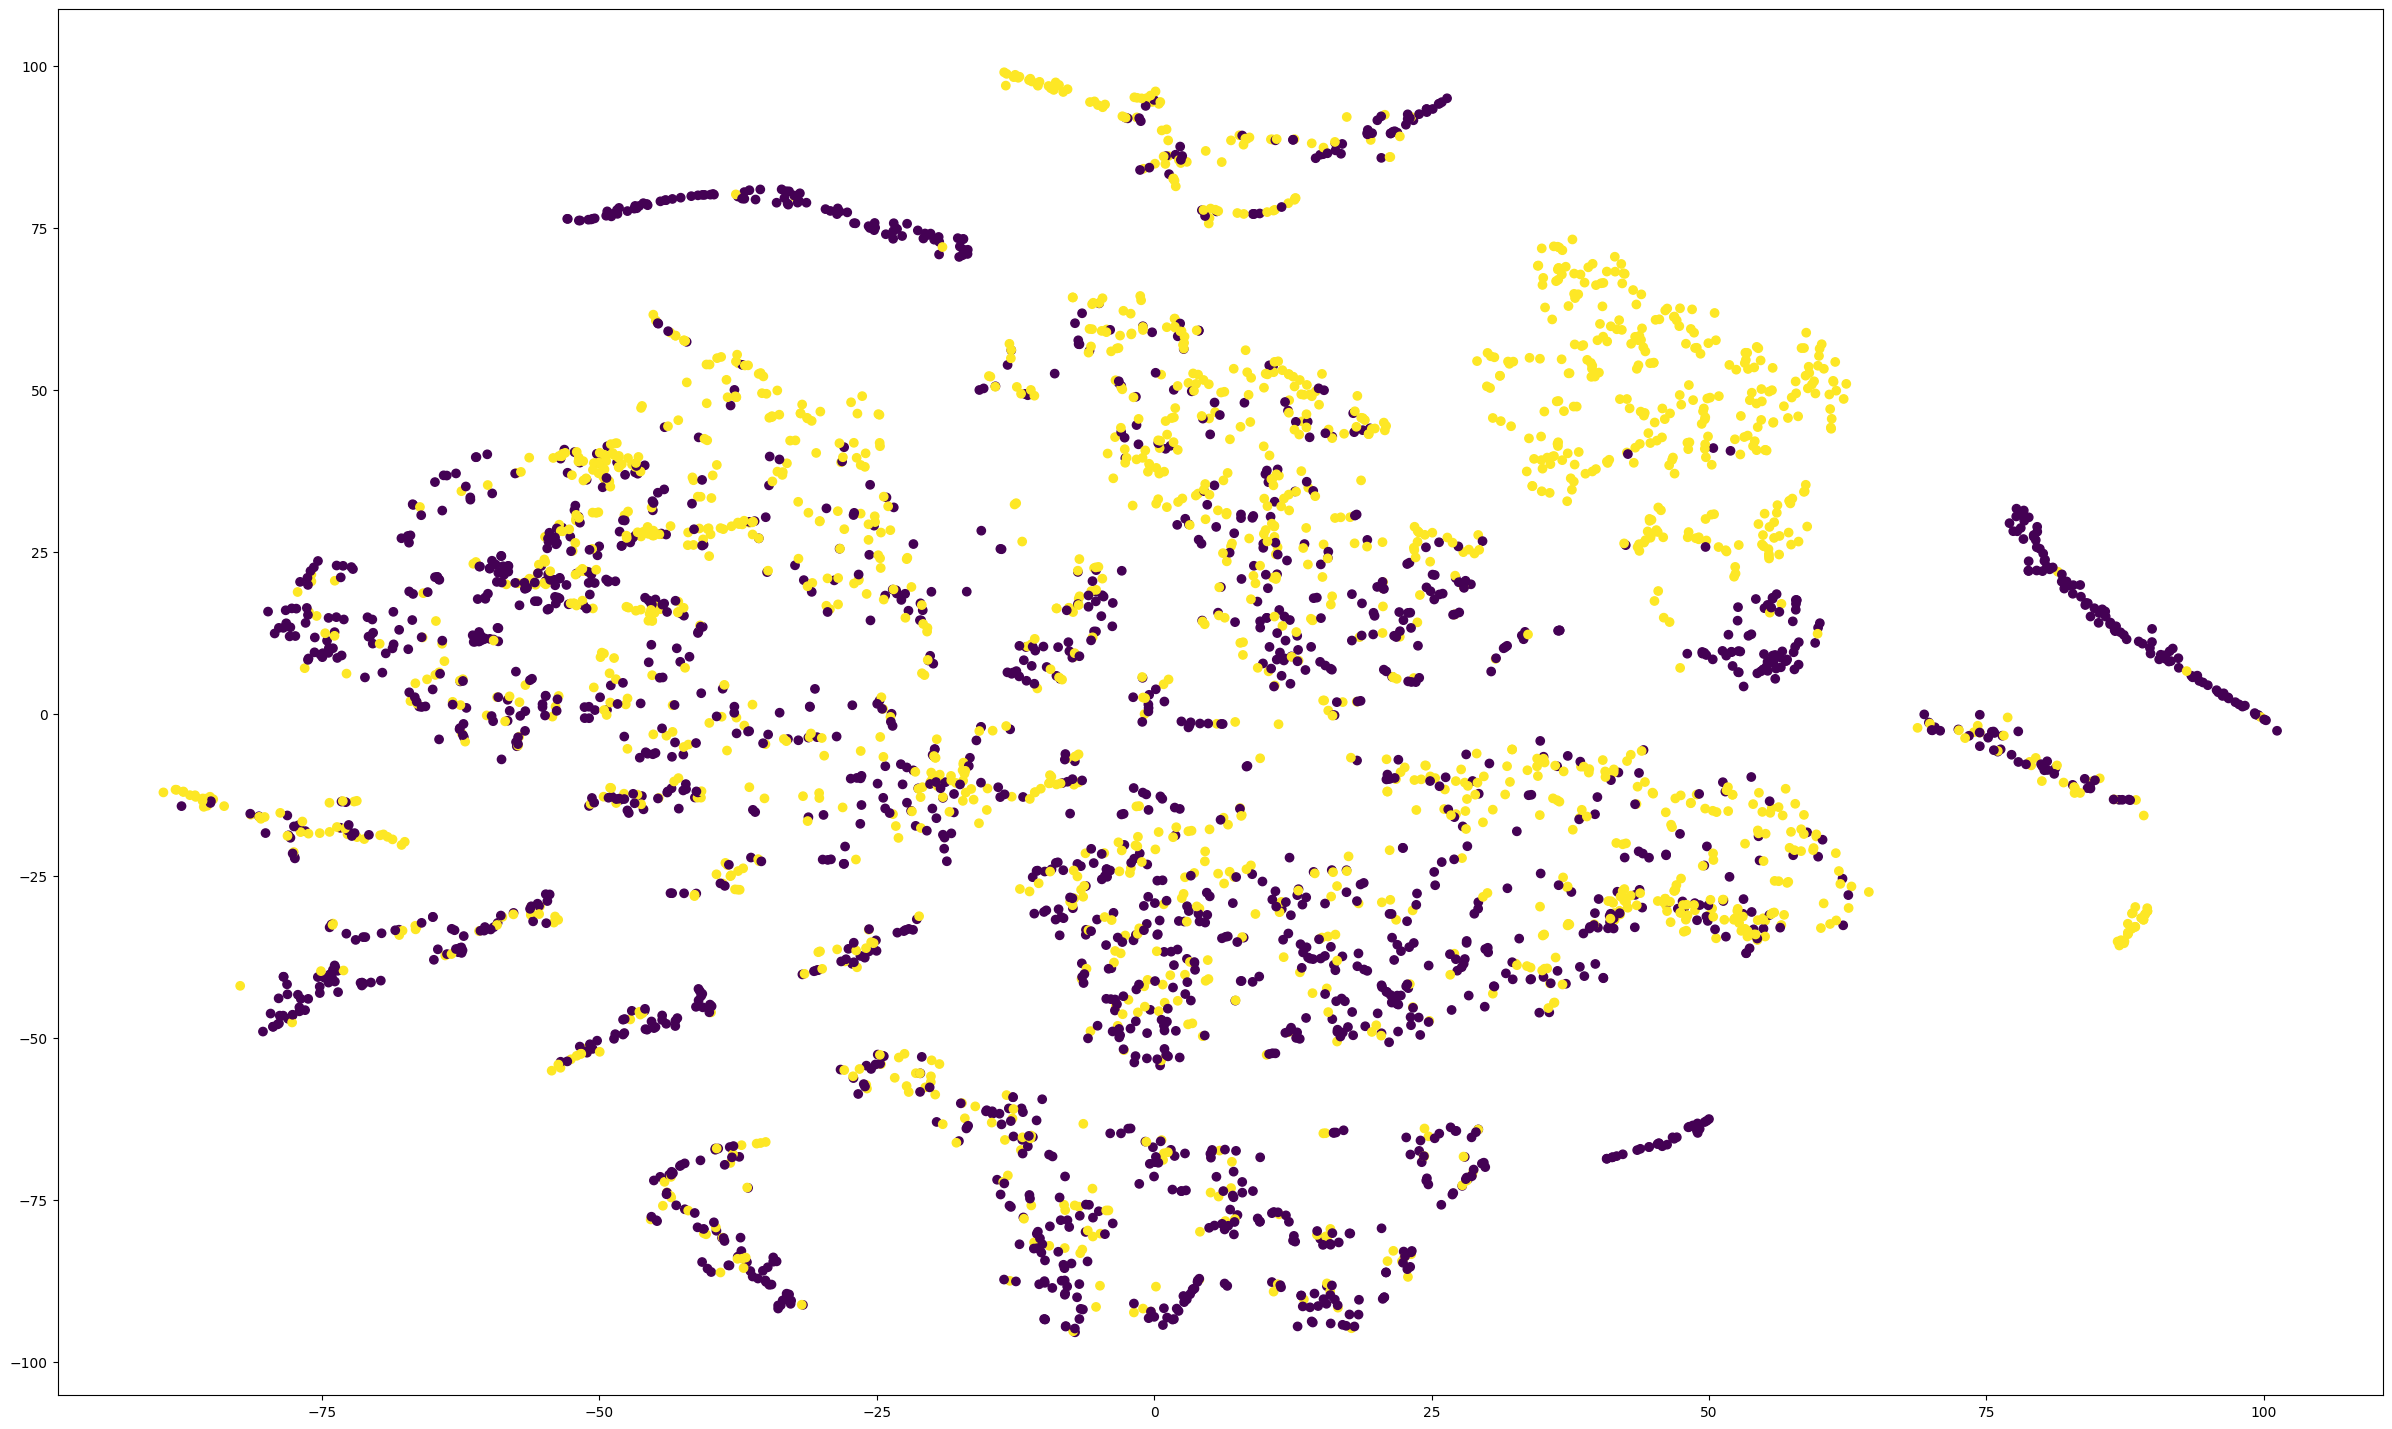

In [195]:

plt.scatter(X_embedded_interm[:, 0], X_embedded_interm[:, 1], c=labels_concat)
plt.show()

In [196]:
color_map = {0:'red', 1:'yellow', 2:'orange', 3:'green', 4:'cyan', 5:'grey'}
colors = list(map(color_map.get, labels))

In [197]:
scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=colors)

NameError: name 'ax' is not defined

In [ ]:
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")

In [ ]:
ax.add_artist(legend1)

In [ ]:
plt.show()

In [ ]:
fig

In [ ]:
scatter.legend_elements()

In [ ]:
X_embedded.shape[0]

In [ ]:
X_embedded.shape[0]//2

In [ ]:
X_embedded_combined = X_embedded[:X_embedded.shape[0]//2, :]

In [ ]:
X_embedded_combined

In [ ]:
X_embedded_local = X_embedded[X_embedded.shape[0]//2:, :]

In [ ]:
X_embedded_local

In [ ]:
x_diff = X_embedded_local - X_embedded_combined

In [ ]:
x_diff

In [ ]:
labels